# Mask Detection Using CNN Layers & Transfer Learning 

sumber dataset: [kaggle.com](https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpig
import pandas as pd
from imutils import paths
import os, zipfile
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense,Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [2]:
os.environ['KAGGLE_USERNAME'] = 'TYPE USERNAME'
os.environ['KAGGLE_KEY'] = 'TYPE KEY'

In [3]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

 94% 195M/207M [00:01<00:00, 106MB/s]
100% 207M/207M [00:02<00:00, 105MB/s]


In [4]:
!unzip -q covid-face-mask-detection-dataset.zip

In [5]:
dataset = r'/content/New Masks Dataset'
imagePaths = list(paths.list_images(dataset))

In [6]:
data = []
labels = []

In [7]:
for i in imagePaths:
    label = i.split(os.path.sep)[-2]
    labels.append(label)
    image = load_img(i,target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)

In [8]:
data = np.array(data,dtype='float32')
labels = np.array(labels)

In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=10)

In [11]:
aug = ImageDataGenerator(
                        rotation_range = 20,
                        zoom_range = 0.15,
                        width_shift_range = 0.2,
                        height_shift_range = 0.2,
                        shear_range = 0.15,
                        fill_mode = 'nearest')

### Transfer Learning Using **MobileNetV2**

In [12]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

9420800/9406464 [==============================] - 0s 0us/step


In [13]:
headModel = base_model.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Flatten(name='Flatten')(headModel)
headModel = Dense(128,activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2,activation='softmax')(headModel)

In [14]:
model = Model(inputs= base_model.input, outputs=headModel)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [16]:
for layer in base_model.layers:
  layer.trainable = False

### Hyperparameter

In [17]:
learning_rate=0.001
Epochs=100
BS=12

In [18]:
class mCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.99):
      print('\nPelatihan dihentikan, Akurasi lebih dari 99% !')
      self.model.stop_training = True

callbacks = mCallback()

### Compile Model

In [19]:
opt = Adam(lr=learning_rate, decay=learning_rate/Epochs)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
history = model.fit(
                aug.flow(X_train, Y_train, batch_size=BS),
                steps_per_epoch=len(X_train) // BS,
                validation_data=(X_test, Y_test),
                validation_steps=len(X_test) // BS,
                callbacks=[callbacks],
                epochs = Epochs
            )

Epoch 1/100
67/67 [==============================] - 46s 562ms/step - loss: 0.1888 - accuracy: 0.9328 - val_loss: 0.0649 - val_accuracy: 0.9802
Epoch 2/100
67/67 [==============================] - 36s 530ms/step - loss: 0.0619 - accuracy: 0.9801 - val_loss: 0.0518 - val_accuracy: 0.9851
Epoch 3/100
67/67 [==============================] - 36s 543ms/step - loss: 0.0305 - accuracy: 0.9975 - val_loss: 0.0491 - val_accuracy: 0.9851
Epoch 4/100
67/67 [==============================] - 37s 557ms/step - loss: 0.0467 - accuracy: 0.9813 - val_loss: 0.0640 - val_accuracy: 0.9752
Epoch 5/100
67/67 [==============================] - 35s 526ms/step - loss: 0.0416 - accuracy: 0.9851 - val_loss: 0.0566 - val_accuracy: 0.9851
Epoch 6/100
67/67 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9938
Pelatihan dihentikan, Akurasi lebih dari 99% !
67/67 [==============================] - 35s 528ms/step - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0446 - val_accuracy: 0.9901


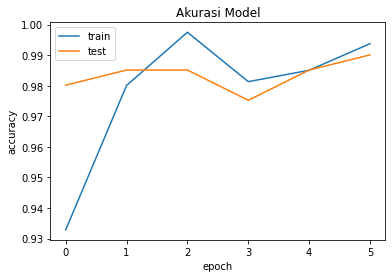

In [21]:
# plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

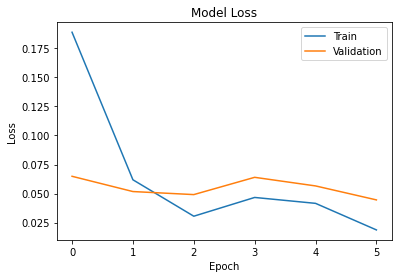

In [22]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [23]:
# PREDICTIONS
predictions = model.predict(X_test)
predict=[]

for i in range(len(predictions)):
  if(predictions[i][0]>0.5):
    predict.append(1)
  else:
    predict.append(0)

In [24]:
predict=model.predict(X_test,batch_size=BS)
predict=np.argmax(predict,axis=1)
print(classification_report(Y_test.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

        Mask       0.98      1.00      0.99       101
    Non Mask       1.00      0.98      0.99       101

    accuracy                           0.99       202
   macro avg       0.99      0.99      0.99       202
weighted avg       0.99      0.99      0.99       202



In [28]:
model.save("mask_detector.model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
